# Select suitable MDL test

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping
* Predict with
    * SI
    * Ikeda

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [18]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
#plt.style.use('paper')

#import data
import copy
from mdldb.tables import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.99)

In [20]:
df_rolldecay.head()

,model_number,loading_condition_id,ship_speed,B_1A,B_2A,C_1A,B_1,B_2,C_1,A_44,omega0,omega0_fft,score,phi_start,phi_stop,id,project_number,series_number,run_number,test_number,ship_name,ascii_name,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp,name,project_path,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
663,3161-A,3,0.0,0.001128,0.609493,6.218059,0.143554,77.556673,791.234160,127.247768,2.493604,2.494425,0.998725,-0.150532,0.013294,663,20053838,2,112,1,3161-A,20053838-ser002-k112-100hz.asc,Kursstyrning Roll decay 0kn,N:\Gamla_Projekt\ascii_files\20053838-ser002-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2005-12-12,roll decay,MDL,None,None,Kursstyrning,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838,-2.450,18.840,4.82,0.858,12.0,12.0,50.0,16.5,71.3,3.18,0.7714,139566.0,0.996,10.2,53.740,302.0,50.0,49.5,-4.1,1.0,9.8,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.4,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.0,None,9.3,36.0,314.0,4.0
664,3161-A,3,20.0,0.188700,0.424259,6.442777,23.174137,52.103029,791.234160,122.809487,2.538263,2.538407,0.998853,-0.128445,0.004254,664,20053838,2,113,1,3161-A,20053838-ser002-k113-100hz.asc,Kursstyrning Roll decay 20kn,N:\Gamla_Projekt\ascii_files\20053838-ser002-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2005-12-12,roll decay,MDL,None,None,Kursstyrning,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838,-2.450,18.840,4.82,0.858,12.0,12.0,50.0,16.5,71.3,3.18,0.7714,139566.0,0.996,10.2,53.740,302.0,50.0,49.5,-4.1,1.0,9.8,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.4,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.0,None,9.3,36.0,314.0,4.0
832,3161-A,4,0.0,0.070507,0.307122,10.684317,9.377447,40.847099,1421.010464,132.999658,3.268687,3.273540,0.995012,0.154490,-0.007978,832,20053838,4,13,1,3161-A,20053838-ser004-k013-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20053838-ser004-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2005-12-22,roll decay,MDL,None,None,Kursstyrning,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838,-1.020,14.930,11.09,0.828,9.6,9.6,50.0,20.0,77.7,2.80,0.7532,108940.0,0.995,10.2,53.740,302.0,50.0,49.5,-4.1,1.0,9.8,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.4,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.0,None,9.3,36.0,314.0,4.0
833,3161-A,4,20.0,0.170708,0.325888,11.007946,22.036611,42.068791,1421.010464,129.089525,3.317822,3.317522,0.999635,0.156054,0.002176,833,20053838,4,14,1,3161-A,20053838-ser004-k014-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20053838-ser004-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2005-12-22,roll decay,MDL,None,None,Kursstyrning,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838,-1.020,14.930,11.09,0.828,9.6,9.6,50.0,20.0,77.7,2.80,0.7532,108940.0,0.995,10.2,53.740,302.0,50.0,49.5,-4.1,1.0,9.8,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.4,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.0,None,9.3,36.0,314.0,4.0
1906,3196-A,9,0.0,0.019066,0.139074,11.371380,2.860200,20.862967,1705.856339,150.013138,3.372148,3.367787,0.990466,-0.145819,0.030832,1906,20064244,0,19,1,3196-A,20064244-ser000-k019-100hz.asc,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20064244-ser000-k...,None,\\sspa.local\gbg\MDLdata\Gamla_Projekt\gamla_p...,None,2006-10-23,roll decay,MDL,None,None,Kursstyrning,20064244,\\sspa.local\gbg\ProjektArkiv\2006\20064244,-9.514,13.828,6.60,0.848,15.0,15.0,43.8,14.0,64.0,NaN,0.8180,143782.0,0.992,NaN,48.333,267.0,43.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [21]:
df_rolldecay.describe()

,loading_condition_id,ship_speed,B_1A,B_2A,C_1A,B_1,B_2,C_1,A_44,omega0,omega0_fft,score,phi_start,phi_stop,id,project_number,series_number,run_number,test_number,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id
count,203.000000,203.000000,2.030000e+02,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,2.030000e+02,203.000000,203.000000,203.0,203.000000,203.000000,203.000000,145.000000,203.000000,203.000000,154.000000,154.000000,154.000000,114.000000,145.000000,203.000000,152.000000,147.000000,203.000000,203.000000,203.000000,115.000000,144.000000,149.000000,115.000000,143.000000,115.000000,115.000000,140.000000,112.000000,133.000000,149.000000,0.0,151.000000,149.000000,112.000000,149.000000,115.000000,115.000000,115.000000,130.000000,155.000000,115.0,115.0,149.000000,149.000000,115.000000,115.000000,115.000000,152.000000,118.000000
mean,86.261084,9.043842,1.472815e-01,0.280980,9.089695,10.227162,21.811772,717.327959,82.715110,2.929405,2.933814,0.997153,-0.005131,0.001334,11162.300493,2.090929e+07,15.374384,23.305419,1.0,4.564456,13.597227,5.920897,0.854834,10.600985,10.849655,42.497273,15.379675,60.729026,2.515456,0.768272,94728.605911,0.989343,9.345782,49.764123,240.995764,40.943990,39.632174,2.146875,0.557047,5.689043,18.080350,10.158783,129.310435,0.873237,9.238304,17635.112782,1.214765,NaN,69.649536,0.357678,2.321429,7.379597,28.891304,2.440209,-112.269565,88.026923,56.362774,0.0,0.0,1.617450,1.026846,-129.867348,7.885652,20.499130,260.263947,3.610169
std,47.753345,7.944972,1.109469e-01,0.252201,4.462473,7.957512,20.916579,431.734176,42.799729,0.714702,0.716432,0.002367,0.144781,0.010632,6314.495087,3.635620e+06,31.411162,16.051752,0.0,20.416420,3.727450,4.242849,0.035356,3.749890,3.546600,9.554548,3.835269,14.183353,0.874691,0.044188,65423.709911,0.013440,2.752563,11.187748,64.309691,10.363617,26.378525,10.229349,0.498410,4.186641,2.541593,2.531274,45.962837,0.125141,7.636946,7262.817613,0.842805,NaN,28.338978,0.148681,0.951190,1.568835,6.972736,0.738691,23.817645,27.351748,30.589359,0.0,0.0,0.501313,0.327693,27.877024,1.240220,15.325512,60.368077,1.934986
min,1.000000,0.000000,6.451552e-18,-0.137137,1.331833,0.000000,-10.870928,0.000000,0.000000,1.154051,1.156106,0.990307,-0.156185,-0.047505,273.000000,2.005384e+07,0.000000,1.000000,1.0,-12.570000,0.000000,0.000000,0.740000,0.000000,0.000000,14.000000,4.990000,16.050000,0.340000,0.536700,0.000000,0.883000,0.000000,16.000000,64.500000,14.000000,0.000000,-29.300000,0.000000,0.000000,10.000000,0.000000,22.000000,0.671000,0.000000,2235.000000,0.000000,NaN,0.000000,0.000000,1.000000,2.200000,13.500000,2.320000,-151.000000,65.100000,0.000000,0.0,0.0,0.000000,1.000000,-172.800000,2.900000,0.000000,70.500000,1.000000
25%,47.000000,0.000000,5.662740e-02,0.136574,6.016941,3.788027,9.126964,318.347679,50.793793,2.452945,2.459867,0.995994,-0.146336,-0.004857,5768.000000,2.009538e+07,1.000000,12.000000,1.0,-1.630000,10.800000,2.710000,0.834000,8.550000,9.000000,42.000000,13.985000,57.600000,2.150000,0.753200,56740.000000,0.987500,8.200000,47.380000,207.785000,34.505000,33.150000,-4.100000,0.000000,0.000000,16.000000,9.200000,108.000000,0.791000,0.000000,10618.000000,1.000000,NaN,56.350000,0.300000,1.000000,6.600000,25.000000,2.320000,-123.500000,74.500000,39.737500,0.0,0.0,1.000000,1.000000,-142.000000,7.300000,8.700000,238.750000,3.000000
50%,91.000000,12.000000,1.188772e-01,0.238711,8.339876,7.868242,17.303507,720.783917,79.527884,2.887884,2.890265,0.997887,-0.114651,0.002565,10346.000000,2.012641e+07,5.000000,21.000000,1.0,0.250000,13.900000,4.820000,0.849000,9.600000,10.000000,45.600000,15.400000,65.210000,2.510000,0.769400,92932.000000,0.992000,9.500000,53.000000,267.000000,44.200000,43.300000,0.000000,1.000000,8.150000,19.500

<AxesSubplot:>

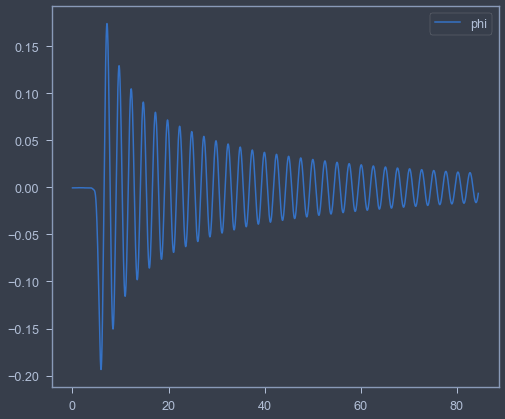

In [23]:
run = df_rolldecay.iloc[0]
run_id = run.name

db_run = db.session.query(Run).get(int(run_id))
df = database.load_run(db_run, save_as_example=False)

fig,ax=plt.subplots()
df.plot(y='phi', ax=ax)